end


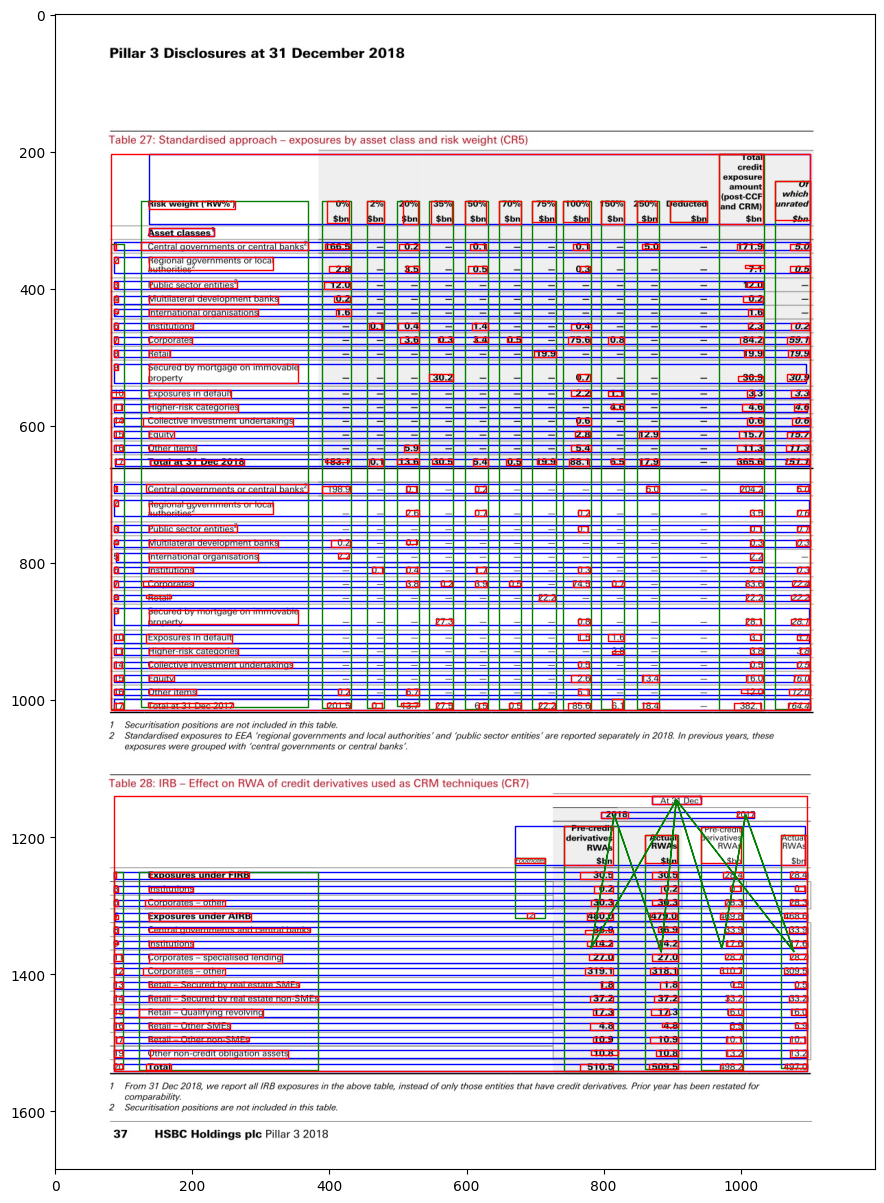

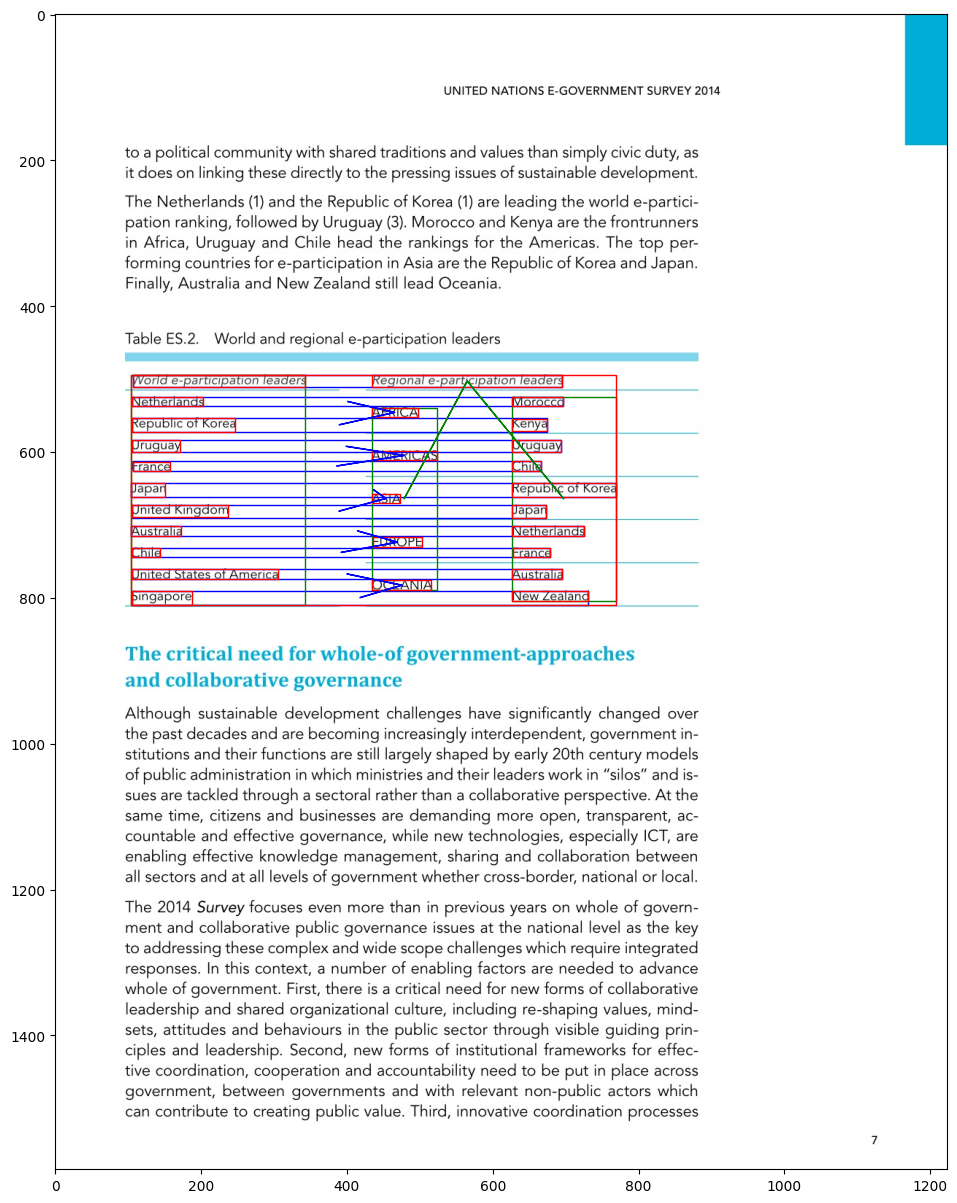

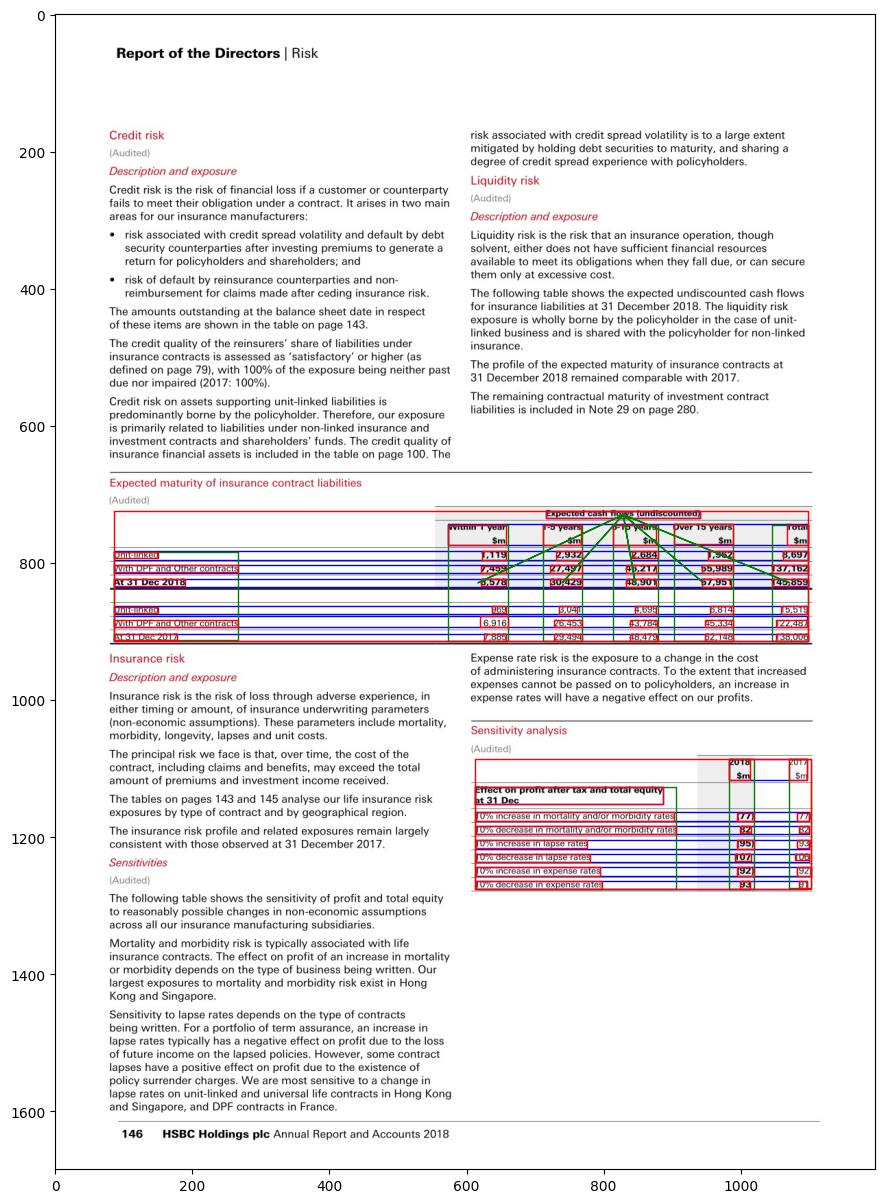

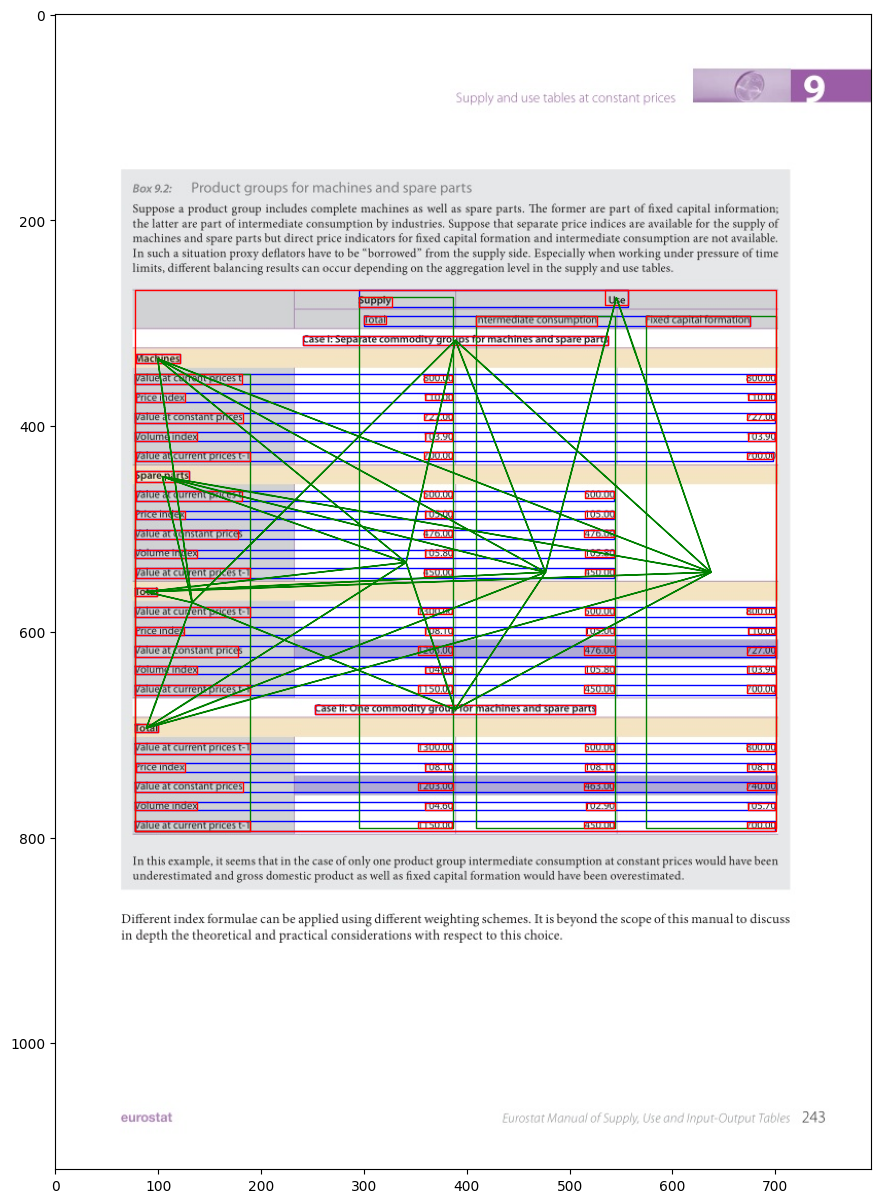

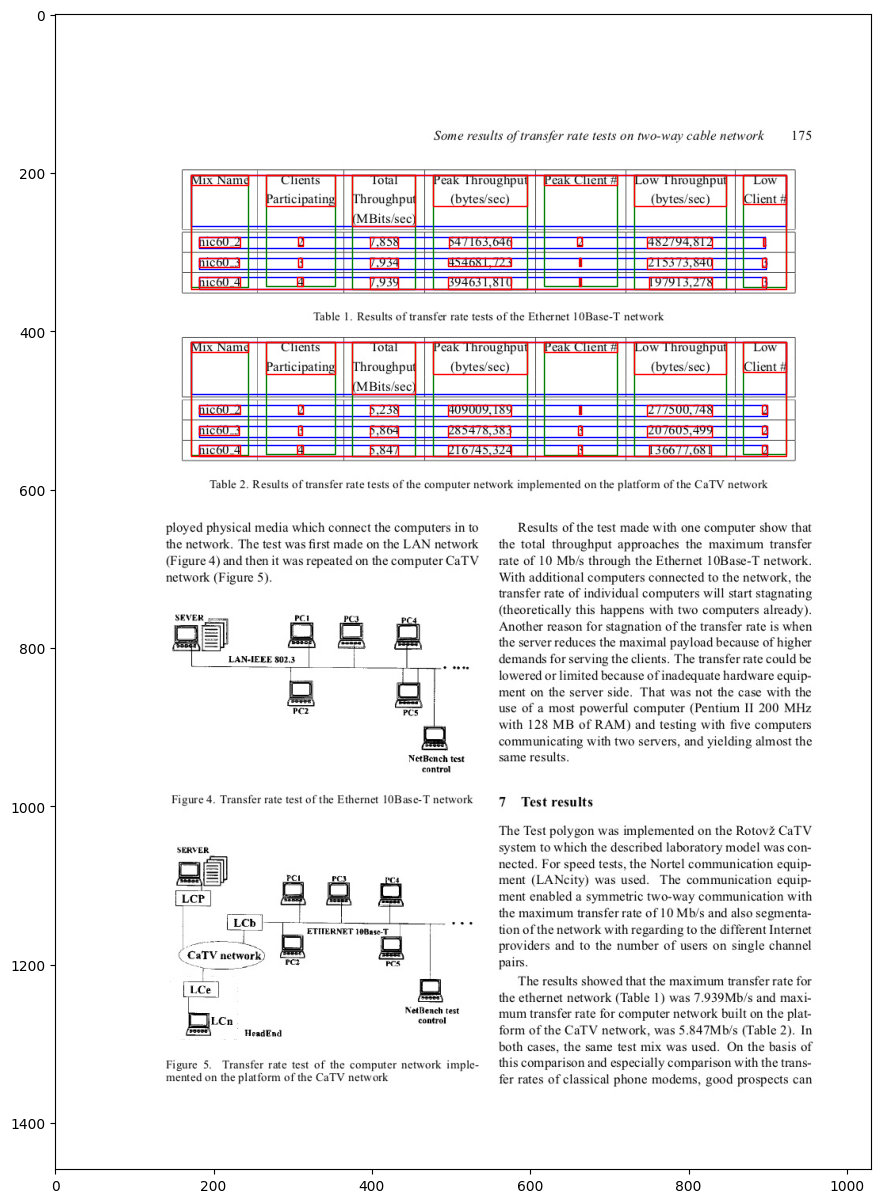

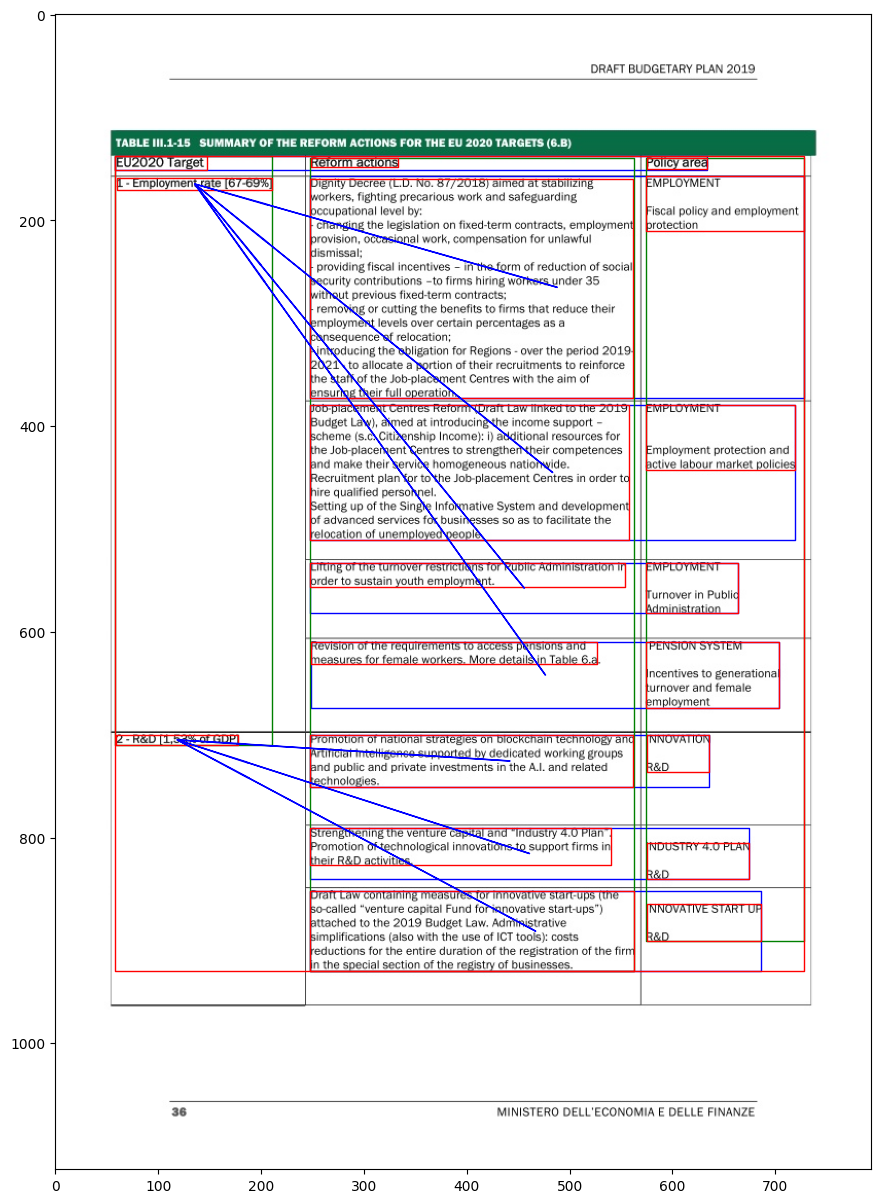

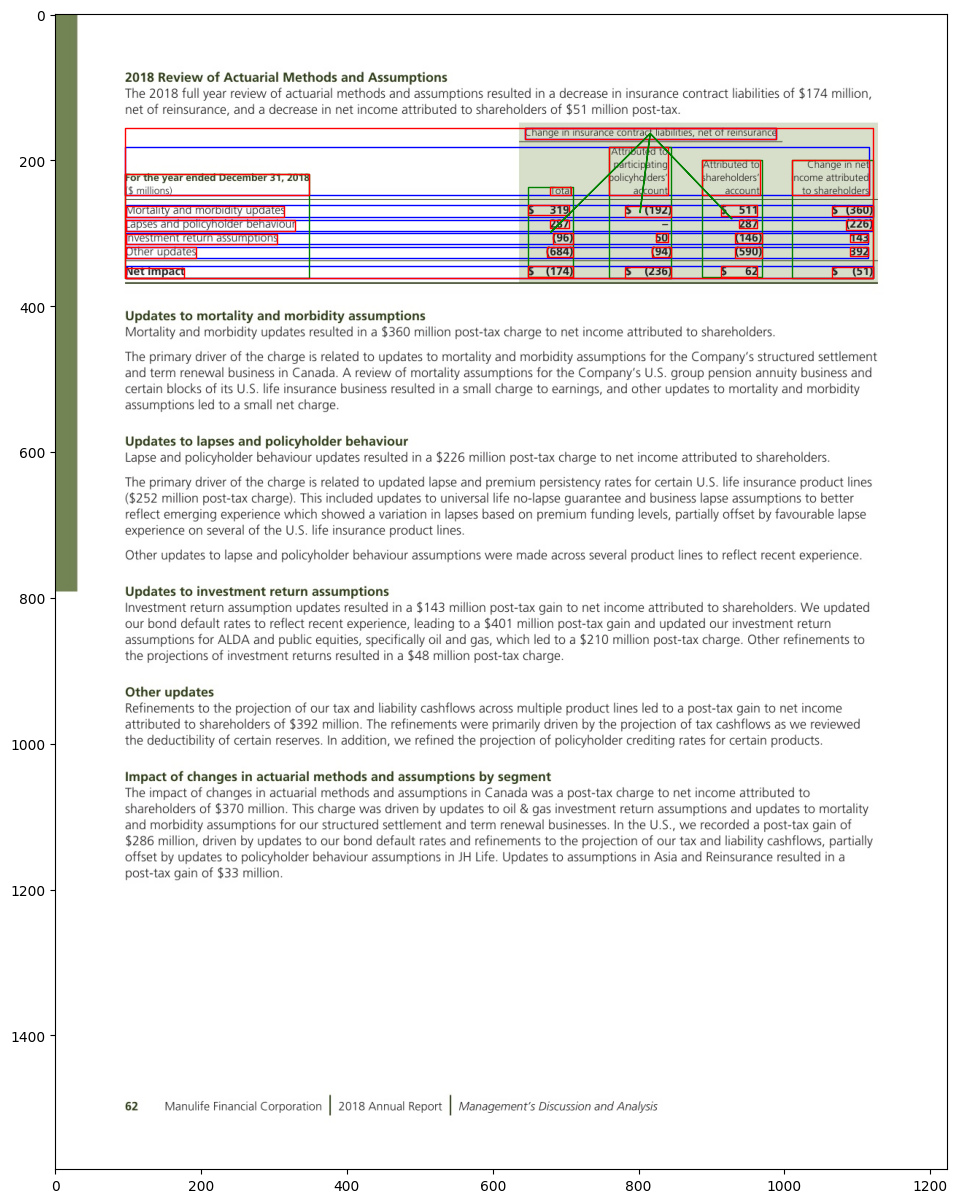

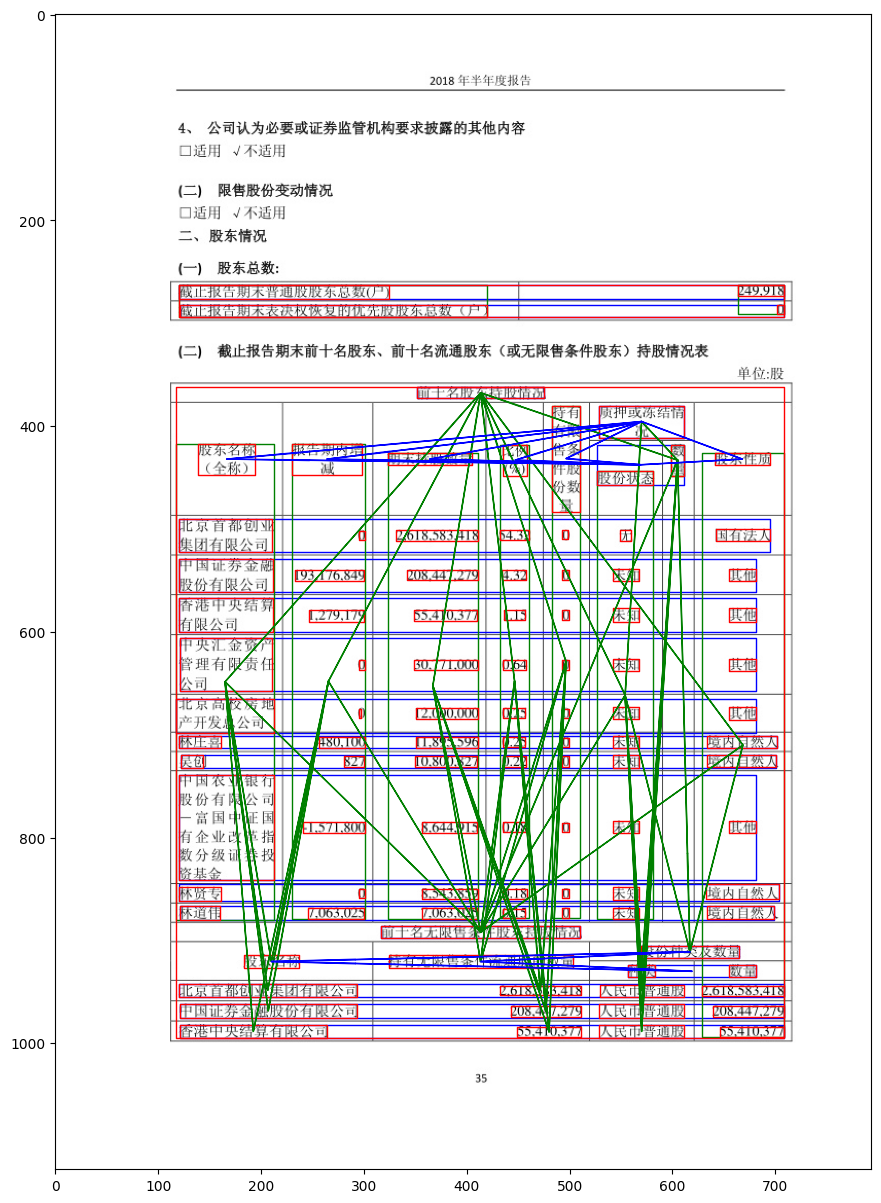

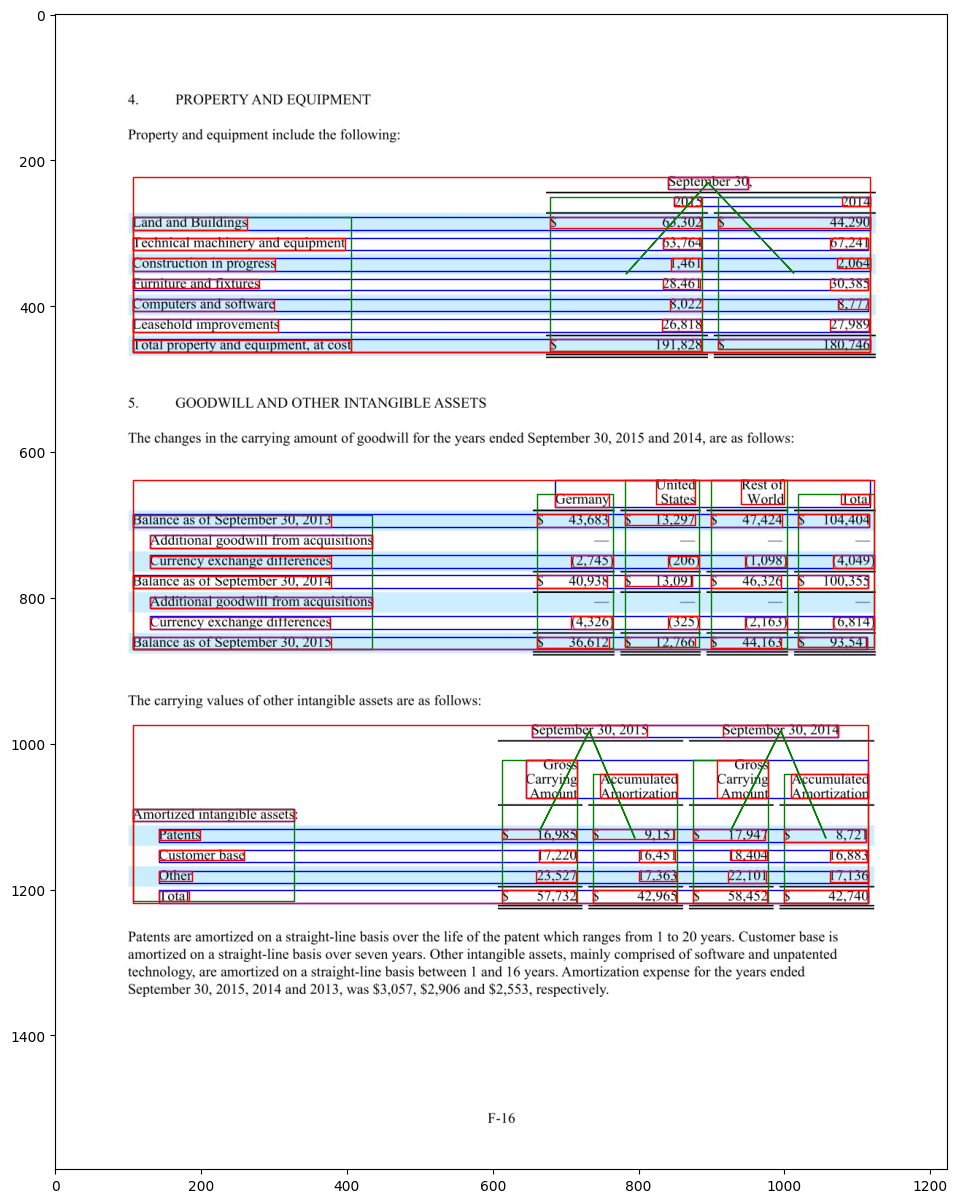

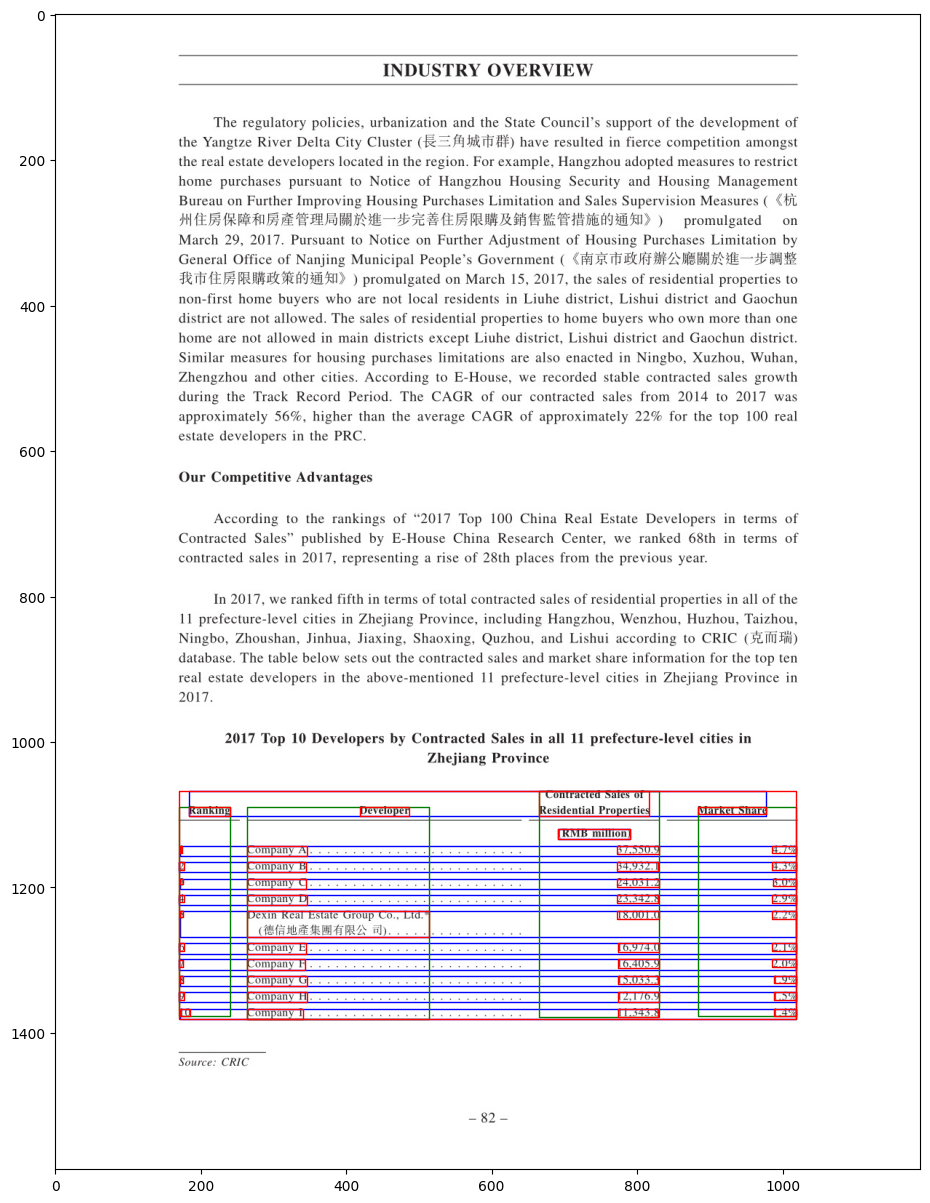

In [161]:
# visualization
# Track A - Table Detection
# Track B - Table Recognition

import os
import sys
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Arrow
from matplotlib.collections import PatchCollection
from PIL import Image
import xml.etree.ElementTree as ET
import glob
from collections import defaultdict



def read_json(json_file: str, class_map=None):
    with open(json_file, 'r') as openfile:
        data = json.load(openfile)
    width, height = data['image_size']
    bboxes = []
    labels = []
    cell_pointers = []

    for label in data['labels']:
        label_name = label['name']
        bbox = label['bbox']
        cell_pointer = label.get('extra_cells', None)

        if label_name == 'table rotated':
            label_name = 'table'

        if class_map.get(label_name, None) is None:
            continue

        label_id = int(class_map[label_name])
        bboxes.append(bbox)
        labels.append(label_id)
        cell_pointers.append(cell_pointer)

    return bboxes, labels, cell_pointers, [width, height]


dataset_path = os.path.join('ICDAR2019_cTDaR', 'recognition', 'val')
# dataset_path = os.path.join('ICDAR2019_cTDaR', 'detection', 'test')


class_map = {'table': 0,
             'column': 1,
             'row': 2,
             'cell': 3}

for f in os.listdir(dataset_path)[:10]:
    if 't1' in f:
        file_name = f.split('.')[0]
        annotation_file_path = os.path.join(dataset_path, f)
        bboxes, labels, cell_pointers, size = read_json(annotation_file_path, class_map)

        im = Image.open(os.path.join(dataset_path, '..', 'images', file_name + '.jpg'))
        fig, ax = plt.subplots(figsize=(30, 15))
        ax.imshow(im)
        cell_rects = []
        row_rects = []
        col_rects = []
        table_rects = []
        col_arrows = []
        row_arrows = []

        for idx, bbox in enumerate(bboxes):
            # shift = labels[idx] * 2
            shift = 0
            rect = Polygon(np.asarray([[bbox[0] + shift, bbox[1] + shift], [bbox[2] + shift, bbox[1] + shift],
                                       [bbox[2] + shift, bbox[3] + shift], [bbox[0] + shift, bbox[3] + shift]]).reshape(-1, 2))
            if labels[idx] == 0:
                table_rects.append(rect)
            elif labels[idx] == 1:
                col_rects.append(rect)
            elif labels[idx] == 2:
                row_rects.append(rect)
            else:
                cell_rects.append(rect)

            if labels[idx] == 1:
                if cell_pointers[idx]:
                    for dst_cell in cell_pointers[idx]:
                        if dst_cell:
                            dst_cell_x_center = (dst_cell[0] + dst_cell[2]) / 2.0
                            dst_cell_y_center = (dst_cell[1] + dst_cell[3]) / 2.0
                            column_x_center = (bbox[0] + bbox[2]) / 2.0
                            column_y_center = (bbox[1] + bbox[3]) / 2.0
                            arrow = Arrow(column_x_center, column_y_center, dst_cell_x_center-column_x_center, dst_cell_y_center-column_y_center)
                            col_arrows.append(arrow)

            if labels[idx] == 2:
                if cell_pointers[idx]:

                    for dst_cell in cell_pointers[idx]:
                        if dst_cell:
                            dst_cell_x_center = (dst_cell[0] + dst_cell[2]) / 2.0
                            dst_cell_y_center = (dst_cell[1] + dst_cell[3]) / 2.0
                            row_x_center = (bbox[0] + bbox[2]) / 2.0
                            row_y_center = (bbox[1] + bbox[3]) / 2.0
                            arrow = Arrow(row_x_center, row_y_center, dst_cell_x_center-row_x_center, dst_cell_y_center-row_y_center)
                            row_arrows.append(arrow)

        ax.add_collection(PatchCollection(row_rects, facecolor='none', edgecolor='blue'))
        ax.add_collection(PatchCollection(col_rects, facecolor='none', edgecolor='green'))
        ax.add_collection(PatchCollection(table_rects, facecolor='none', edgecolor='red'))
        ax.add_collection(PatchCollection(cell_rects, facecolor='none', edgecolor='red'))

        ax.add_collection(PatchCollection(col_arrows, facecolor='none', edgecolor='green'))
        ax.add_collection(PatchCollection(row_arrows, facecolor='none', edgecolor='blue'))

print('end')


In [128]:
# Track A - Table Detection test dataset preparation

import os
import sys
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from matplotlib.collections import PatchCollection
from PIL import Image
import xml.etree.ElementTree as ET
import glob
from collections import defaultdict
from pascal_voc_writer import Writer



def read_pascal_voc(xml_file: str, class_map=None):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    tables = []

    for table in root.iter('table'):
        bboxes = []
        points = table.find("Coords").attrib['points']
        bbox = points.split(' ')
        bbox = [b.split(',') for b in bbox]
        tables.append(bbox)
    return tables


dataset_path = os.path.join('ICDAR2019_cTDaR', 'detection', 'test_tmp')

for f in os.listdir(dataset_path):
    if '.xml' in f.lower():
        file_name = f.split('.')[0]
        im = Image.open('ICDAR2019_cTDaR/detection/images/' + file_name + '.jpg')
        annotation_file_path = os.path.join('ICDAR2019_cTDaR', 'detection', 'test_tmp', f)
        tables = read_pascal_voc(annotation_file_path)

        json_writer = {'image_size': [im.size[0], im.size[1]], 'labels': []}
        for table in tables:
            json_writer['labels'].append({'name': 'table',
                                          'bbox': [int(table[0][0]), int(table[0][1]),
                                                   int(table[2][0]), int(table[2][1])]})

        with open('ICDAR2019_cTDaR/detection/test/' + file_name + '.json', "w") as outfile:
            json.dump(json_writer, outfile)

print('end')

end


In [141]:
# Track B - Table Recognition test dataset preparation

import os
import sys
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from matplotlib.collections import PatchCollection
from PIL import Image
import xml.etree.ElementTree as ET
import glob
from collections import defaultdict



def read_pascal_voc(xml_file: str, class_map=None):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    tables = []

    for table in root.iter('table'):
        bboxes = []
        rows = defaultdict(list)
        cols = defaultdict(list)
        columns_to_cells_aux = defaultdict(list)
        rows_to_cells_aux = defaultdict(list)

        for object_ in table.iter('cell'):
            ymin, xmin, ymax, xmax = None, None, None, None
            start_row_id = int(object_.attrib['start-row'])
            end_row_id = int(object_.attrib['end-row'])
            start_col_id = int(object_.attrib['start-col'])
            end_col_id = int(object_.attrib['end-col'])

            points = object_.find("Coords").attrib['points']
            bbox = points.split(' ')
            bbox = [b.split(',') for b in bbox]

            if start_row_id == end_row_id:
                rows[start_row_id].append(bbox)
            else:
                bbox_tmp = np.asarray(bbox).astype(int)
                x_min = int(np.round(np.amin(bbox_tmp[:, 0])))
                x_max = int(np.round(np.amax(bbox_tmp[:, 0])))
                y_min = int(np.round(np.amin(bbox_tmp[:, 1])))
                y_max = int(np.round(np.amax(bbox_tmp[:, 1])))
                bbox_new = [x_min, y_min, x_max, y_max]

                for row_id in range(start_row_id, end_row_id+1):
                    rows_to_cells_aux[row_id].append(bbox_new)

            if start_col_id == end_col_id:
                cols[start_col_id].append(bbox)
            else:
                bbox_tmp = np.asarray(bbox).astype(int)
                x_min = int(np.round(np.amin(bbox_tmp[:, 0])))
                x_max = int(np.round(np.amax(bbox_tmp[:, 0])))
                y_min = int(np.round(np.amin(bbox_tmp[:, 1])))
                y_max = int(np.round(np.amax(bbox_tmp[:, 1])))
                bbox_new = [x_min, y_min, x_max, y_max]

                for col_id in range(start_col_id, end_col_id+1):
                    columns_to_cells_aux[col_id].append(bbox_new)
            bboxes.append(bbox)
        tables.append([bboxes, rows, cols, rows_to_cells_aux, columns_to_cells_aux])
    return tables


dataset_path = os.path.join('ICDAR2019_cTDaR', 'recognition', 'test_tmp')


for f in os.listdir(dataset_path):
    if 't1' in f:
        file_name = f.split('.')[0]
        annotation_file_path = os.path.join(dataset_path, f)
        tables = read_pascal_voc(annotation_file_path)

        im = Image.open(os.path.join(dataset_path, '..', 'images', file_name + '.jpg'))
        json_writer = {'image_size': [im.size[0], im.size[1]], 'labels': []}

        for table in tables:
            tab = table[0]
            tab = np.asarray(tab).astype(int)
            x_min = int(np.round(np.amin(tab[:, :, 0])))
            x_max = int(np.round(np.amax(tab[:, :, 0])))
            y_min = int(np.round(np.amin(tab[:, :, 1])))
            y_max = int(np.round(np.amax(tab[:, :, 1])))
            json_writer['labels'].append({'name': 'table',
                                          'bbox': [x_min, y_min, x_max, y_max]})

            rows = table[1]
            for row_key in rows:
                row = np.asarray(rows[row_key]).astype(int)
                x_min = int(np.round(np.amin(row[:, :, 0])))
                x_max = int(np.round(np.amax(row[:, :, 0])))
                y_min = int(np.round(np.amin(row[:, :, 1])))
                y_max = int(np.round(np.amax(row[:, :, 1])))
                list_of_cells_to_point = table[3][row_key]
                json_writer['labels'].append({'name': 'row',
                                              'bbox': [x_min, y_min, x_max, y_max],
                                              'extra_cells': list_of_cells_to_point})

            cols = table[2]
            for col_key in cols:
                col = np.asarray(cols[col_key]).astype(int)
                x_min = int(np.round(np.amin(col[:, :, 0])))
                x_max = int(np.round(np.amax(col[:, :, 0])))
                y_min = int(np.round(np.amin(col[:, :, 1])))
                y_max = int(np.round(np.amax(col[:, :, 1])))
                list_of_cells_to_point = table[4][col_key]
                json_writer['labels'].append({'name': 'column',
                                              'bbox': [x_min, y_min, x_max, y_max],
                                              'extra_cells': list_of_cells_to_point})

            for cell in table[0]:
                bbox = np.asarray(cell).astype(int)
                x_min = int(np.round(np.amin(bbox[:, 0])))
                x_max = int(np.round(np.amax(bbox[:, 0])))
                y_min = int(np.round(np.amin(bbox[:, 1])))
                y_max = int(np.round(np.amax(bbox[:, 1])))
                writer.addObject('cell', x_min, y_min, x_max, y_max)
                json_writer['labels'].append({'name': 'cell',
                                              'bbox': [x_min, y_min, x_max, y_max]})

        with open(os.path.join(dataset_path, '..', 'test', file_name + '.json'), "w") as outfile:
            json.dump(json_writer, outfile)

print('End')

End
